## HW2: KNN from scratch

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import operator

from collections import OrderedDict
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering,KMeans,SpectralClustering
%matplotlib inline

In [2]:
def generate_clustering(data,method,n):
    #X = np.hstack([data,np.random.randint(0,2,650).reshape(-1,1)])
    #X = np.hstack([data,np.append(np.ones(325),np.zeros(325)).reshape(-1,1)])

    if method=="Kmeans":
        kmeans = KMeans(n_clusters=n,random_state=14).fit(data)
        return kmeans.predict(data)
    elif method=="Spectral":
        spectral = SpectralClustering(n,random_state=17)
        return spectral.fit_predict(data)
    else:
        agg = AgglomerativeClustering()
        return agg.fit_predict(data)
    return X

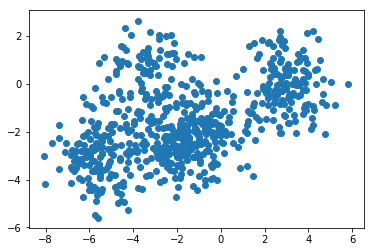

In [3]:
n=3#number of clusters
np.random.seed(37)
data = np.vstack(((np.random.randn(150, 2)  + np.array([3, 0])),
               (np.random.randn(100, 2)  + np.array([-3.5, 0.5])),
               (np.random.randn(100, 2) + np.array([-0.5, -2])),
               (np.random.randn(150, 2) + np.array([-2, -2.5])),
               (np.random.randn(150, 2) + np.array([-5.5, -3]))))

clusters = generate_clustering(data,"Spectral",n)
X = np.hstack([data,clusters.reshape(-1,1)])

plt.scatter(X[:,0],X[:,1])

train,test = train_test_split(X)
X_tr,Y_tr = train[:,:2],train[:,2]
X_t,Y_t = test[:,:2],test[:,2]

C:\Users\alexa\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


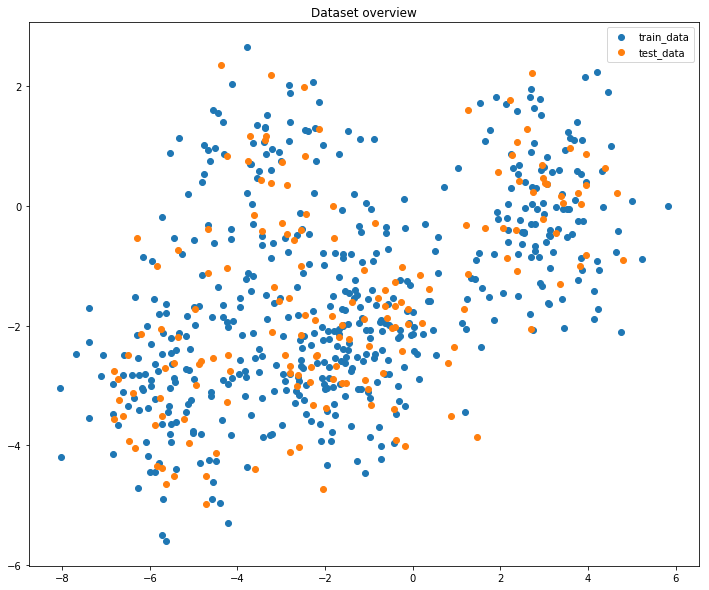

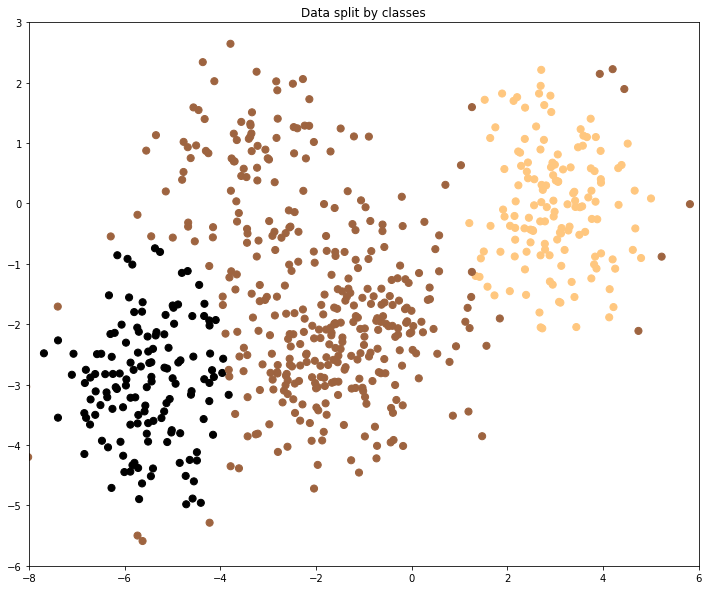

In [6]:
a1 = plt.figure(figsize=(12,10))
plt.scatter(X_tr[:,0],X_tr[:,1],label='train_data')
plt.scatter(X_t[:,0],X_t[:,1],label='test_data')

plt.title("Dataset overview")
plt.legend()
a1.show()
visualise_classes(train,test,Y_t.astype(int),demo=True,figsize=(12,10))

### Pure KNN

In [7]:
class KNN(object):
    """
    KNN for classification 
    
    Argumants:
    ---------
    k -- number of nearest neighbours
    X -- input matrix of shape ()
    n -- number of classes
    method -- str -- can use 'parzen' or 'potentials'. Otherwise, will run simple KNN
    
    """
    def euclidean_dist(self,x,y):
        """
        euclidean distance between points x and y
        """
        #print(x,y)
        if type(x)==np.float64:
            return ((y-x)**2)**0.5
        return sum((y[i]-x[i])**2 for i in range(len(x)))**0.5
    
    
    def split_data(self):
        train_data, test_data = train_test_split(self.X)
        self.X_train, self.Y_train = train_data[:,:2],train_data[:,2]
        self.X_test, self.Y_test = test_data[:,:2],test_data[:,2]
        
        
    def __init__(self,k,X=None,X_train=None,X_test=None,Y_train=None,Y_test=None):
        self.k = k
        if X is None:
            self.X_train,self.X_test = X_train,X_test
            self.Y_train,self.Y_test = Y_train,Y_test
            self.n = len(np.unique(Y_tr))
        else:
            self.X = X
            self.split_data()
            self.n = len(np.unique(X[:,-1]))
        
            
    def get_neighbours(self,point,flag=None):
        """
        Arguments:
        ---------
        point -- array of shape(,), chosen point from test
        Returns:
        ---------
        list of indices of k nearest points
        
        """
        #calculate k closest points from train
        distances = {self.euclidean_dist(self.X_train[i],point) : i for i in range(len(self.X_train)) if (self.X_train[i]!=point).all() }
        distances = OrderedDict(sorted(distances.items()))
        
        if flag=="parzen":
            return distances
        
        #return indices of k closest points
        k_nearest = list(distances.items())[:self.k]
        return [row[1] for row in k_nearest]
        
        
    def vote(self,k_neighbours):
        """
        returns most frequent class among k_neighbours
        """
        return np.argmax(np.bincount(self.Y_train.astype(int)[k_neighbours]))
        
        
    def predict(self):
        """
        returns predictions for test set
        """
        prediction = []
        # for each point in test 
        for point in self.X_test:
            #get indexes of k closest points
            k_neighbours = self.get_neighbours(point)
            #select class based on 'voting' process
            prediction.append(self.vote(k_neighbours))
        self.pred = np.array(prediction)
        return self.pred
    
    def calculate_accuracy(self):
        count = sum(1 for i in range(len(self.pred)) if self.pred[i]==self.Y_test[i])
        return count/len(self.pred)

#### Testing simple KNN

accuracy:0.9815950920245399


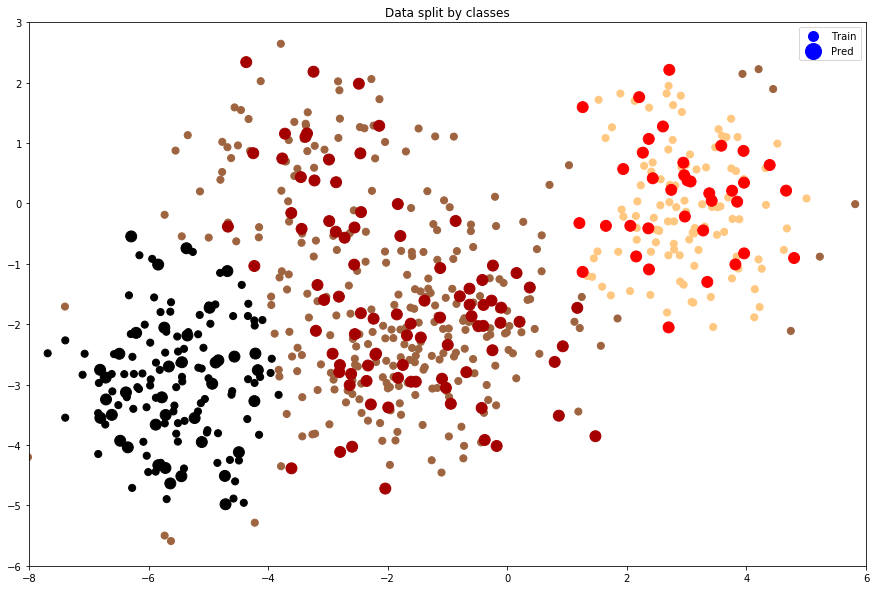

In [8]:
model = KNN(k=10,X_train=X_tr,X_test=X_t,Y_train=Y_tr,Y_test=Y_t)
pred = model.predict()
print("accuracy:{0}".format(model.calculate_accuracy()))
visualise_classes(train,test,pred)

### Parzen windows

In [9]:
class Parzen(KNN):
    """
    KNN using Parzen window 
    Arguments:
    ---------
    h -- window width
    """ 
    def __init__(self,h,X=None,X_train=None,Y_train=None,X_test=None,Y_test=None):
        self.h = h
        self.k = len(X_train)
        self.X_train=X_train
        self.Y_train=Y_train
        self.X_test=X_test
        self.Y_test=Y_test
        
        super().__init__(self.k,X=X,X_train=self.X_train,Y_train=self.Y_train,X_test=self.X_test,Y_test=self.Y_test)

    def select_neighbours(self,point):
        """
        Arguments:
        ---------
        point -- array of shape(,), chosen point from test
        Returns:
        ---------
        all nearest points at distances no more than width of a Parzen window 
        """
        neighbours = super().get_neighbours(point,'parzen')
        indices,distances = list(neighbours.values()), (neighbours.keys())
        
        i = sum(1 if d<=self.h else 0 for d in distances)
            
        return indices[:i]
    
    def modify_h(self,point):
        neighbours = super().get_neighbours(point,'parzen')
        indices,distances = list(neighbours.keys()), list(neighbours.values())
        self.h = self.h*0.33 + distances[0]
        
    def predict(self):
        """
        returns predictions for test set
        """
        prediction = []
        for point in self.X_test:
        #get indexes of k closest points
            neighbours = self.select_neighbours(point)
            #if not neighbours:
                #self.modify_h(point)
                #self.predict()
            prediction.append(super().vote(neighbours)) if neighbours else prediction.append(None)
                
            
        self.pred = np.array(prediction)
        return self.pred

accuracy:0.9754601226993865


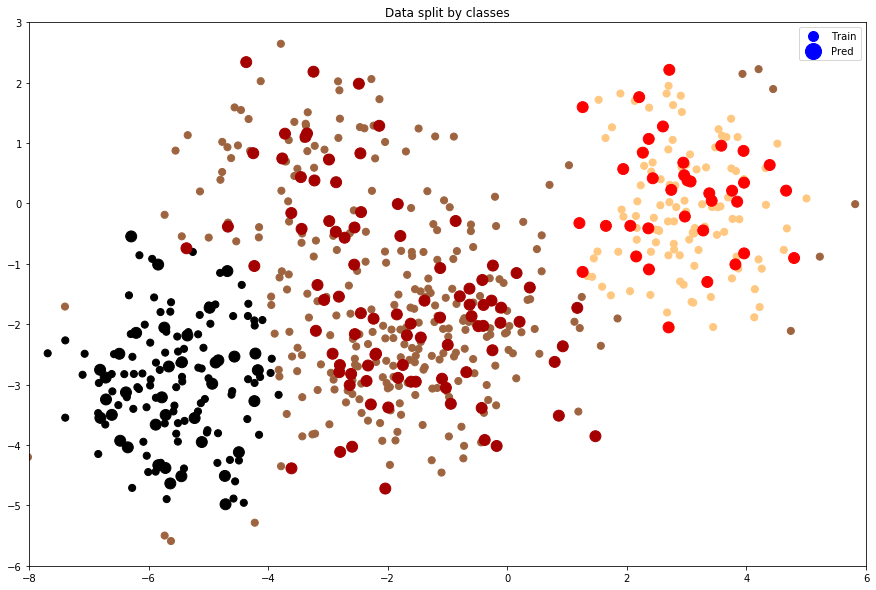

In [10]:
model_parzen = Parzen(0.85,None,X_train=X_tr,Y_train=Y_tr,X_test=X_t,Y_test=Y_t)
pred2 = model_parzen.predict()
print("accuracy:{0}".format(model_parzen.calculate_accuracy()))
visualise_classes(train,test,pred2)

### [Відбір еталонних сусідів](http://synset.com/ai/ru/recognition/Recognition_01_Etalons.html#aver)

Використовується для зменшення розмірності

In [11]:
class Reduction(object):
    """
    Arguments:
    ---------
    data -- combined dataset, array of shape(num_examples,num_of_dims+1) 
    k -- number of classes
    n -- number of rows to be excluded
    Returns:
    --------
    reduced -- reduced dataset, array of shape(num_examples-n,num_of_dims+1)
    """
    def euclidean_dist(self,x,y):
        """
        euclidean distance between points x and y
        """
        if type(x)==np.float64:
            return ((y-x)**2)**0.5
        return sum((y[i]-x[i])**2 for i in range(len(x)))**0.5
    
    
    def __init__(self,data,n):
        self.data = data
        self.n = n
        self.k = len(np.unique(data[:,-1]))
    
    def get_centroids(self):
        """
        returns k central points for k classes
        """
        classes = [i for i in range(self.k)]
        centroids = []
        for i in classes:
            indices = np.where(self.data[:,-1]==i)
            centroids.append(np.mean(self.data[indices][:,:-1],axis=0))
        return np.array(centroids)
        
    def get_distances(self):
        """
        returns {point_id:distance to closest centroid}
        """
        distances = {}
        for i in range(len(self.data)):
           
            centroid_index = int(self.data[i][-1])
            centroid = self.centroids[centroid_index]
            dist = self.euclidean_dist(centroid,self.data[i][:-1])       
            distances[i] = dist
        distances = sorted(distances.items(),key=operator.itemgetter(1),reverse=True)
        return distances
    
    def reduce(self):
        self.centroids = self.get_centroids()
        self.distances = self.get_distances()
        indices = [i for i in range(len(self.data))]
        indices_to_remove = [self.distances[:self.n][i][0] for i in range(self.n)]
        
        indices_to_keep = list(set(indices)-set(indices_to_remove))
        self.reduced = np.copy(self.data[indices_to_keep])
        return self.reduced

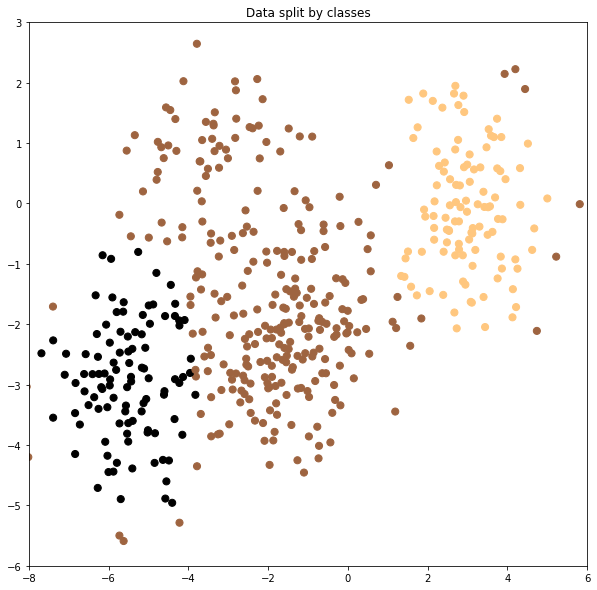

In [12]:
visualise_classes(None,None,None,data=train,figsize=(10,10))

In [13]:
r = Reduction(train,30)
reduced = r.reduce()

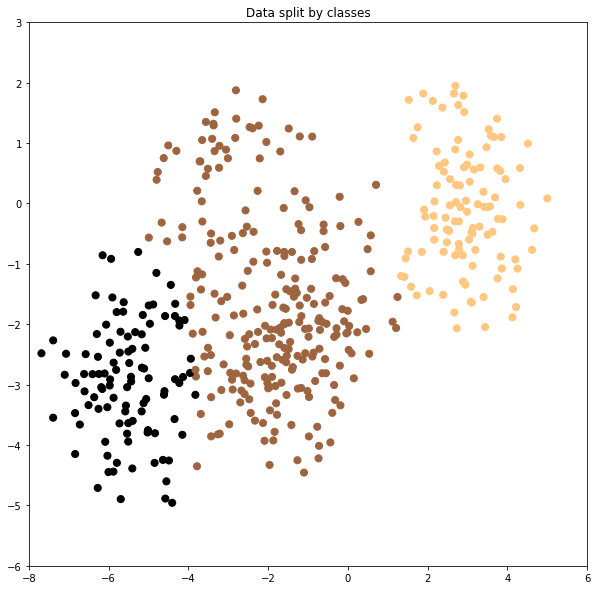

In [14]:
visualise_classes(None,None,None,data=reduced,figsize=(10,10))

### Visualisation

In [5]:
def visualise_classes(train,test,pred_labels,figsize=(15,10),data=None,demo=False):
    plt.figure(figsize=figsize)
    
    if data is not None:
        train = data
    
    c = len(np.unique(train[:,-1]))
    colormap = plt.cm.binary_r
    colors =[x/(2*c) for x in range(2*c)]
    
    train_map = [colors[i] for i in train[:,-1].astype(int)]
    
    if data is None:
        test_map = [colors[i+c] for i in test[:,-1].astype(int)]
        pred_map = [colors[i+c] for i in pred_labels[:]]

    plt.scatter(train[:,0],train[:,1],c = train_map,cmap=plt.cm.copper,s=50,marker='o')
    if demo:
        plt.scatter(test[:,0],test[:,1],c = test_map,cmap=plt.cm.copper,s=50,marker='o')
    elif data is None:
        plt.scatter(test[:,0],test[:,1],c = pred_map,cmap=plt.cm.flag_r,s=120,marker='o')
        plt.plot([],marker='o',ms=10,ls="",color="b",label="Train")
        plt.plot([],marker='o',ms=16,ls="",color="b",label="Pred")
        plt.legend()

    
    
    plt.title('Data split by classes')
    plt.axis([-8,6,-6,3])
   
    

    plt.show()